# 2. End-to-End Machine Learning Project


### Settings

<H2 style = "text-align:center"> os module</H2>

`os.mkdir` 與 `os.makedirs` 都是用來建立新目錄的函數，但是有幾個差異：
1. `os.mkdir` 只能建立一層目錄，若目錄的上層目錄不存在，則會拋出 FileNotFoundError 的異常，因此必須先建立上層目錄才能使用此函數。
而 `os.makedirs` 則可以建立多層目錄，若上層目錄不存在，則會自動建立。

2. `os.mkdir` 的函數原型為 `os.mkdir(path, mode=0o777, *, dir_fd=None)`，其中 `mode` 參數可以指定新建目錄的權限。而 `os.makedirs` 的函數原型為 `os.makedirs(name, mode=0o777, exist_ok=False)`, 其中 `exist_ok` 參數為 False 時，如果目錄已經存在，則會拋出 FileExistsError 的異常。

因此，如果需要建立多層目錄或是確定上層目錄已存在，建議使用 `os.makedirs`。反之，若只需建立一層目錄且確定上層目錄已存在，則可以使用 `os.mkdir`。

<H2 style = "text-align:center"> pathlib module</H2>

在 `Path.mkdir()` 方法中，`parents` 參數可以用來建立不存在的父目錄。

如果將 `parents` 設置為 True，那麼 `mkdir()` 將會建立不存在的父目錄。例如，如果你呼叫 Path("foo/bar/baz").mkdir(parents=True)，且 foo 和 bar 目錄都不存在，mkdir() 會建立這兩個目錄以及 baz 目錄。

如果 `parents` 設置為 False（預設值），那麼 `mkdir()` 將只建立路徑中最後一個目錄，如果任何父目錄不存在則會拋出 <span style="color:red">FileNotFoundError</span>。

In [1]:
from pathlib import Path
import tarfile
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

IMAGES_PATH = Path("images") / 'Chapter 2 end to end project'
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# plt setting

params = {
   'font.size': 14,
   'axes.labelsize': 14,
   'axes.titlesize': 14,
   'legend.fontsize': 14,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
}

plt.rcParams.update(params)

### Get the DataGet the Data
### Download the Data

In [2]:
def save_fig(figname, tight_layout=True, figext="png", resolution=300, update=False):
    full_figname = f"{figname}.{figext}"
    figpath = IMAGES_PATH / full_figname
    if tight_layout:
        plt.tight_layout()
    if update or not figpath.is_file():
        plt.savefig(figpath, format=figext, dpi=resolution)
    else:
        print(f"File '{full_figname}' already exists, use 'update=True' to overwrite")

In [3]:
def load_housing_data(destination_dir='datasets', filename='housing.tgz', 
                      source_url='https://github.com/ageron/data/raw/main/housing.tgz'):
    tgz_path = Path(destination_dir) / filename
    if not tgz_path.is_file():
        Path(destination_dir).mkdir(parents=True, exist_ok=True)
        urllib.request.urlretrieve(source_url, tgz_path)
        with tarfile.open(tgz_path) as housing_tgz:
            housing_tgz.extractall(path=destination_dir)
    return pd.read_csv(Path(destination_dir) / Path(filename).stem / Path(filename).with_suffix('.csv'))
housing = load_housing_data()

#### Take a Quick Look at the Data Structure

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


發現`total_bedrooms`有null值，後續分析要處理缺值問題。

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


File 'attribute_histogram_plots.png' already exists, use 'update=True' to overwrite


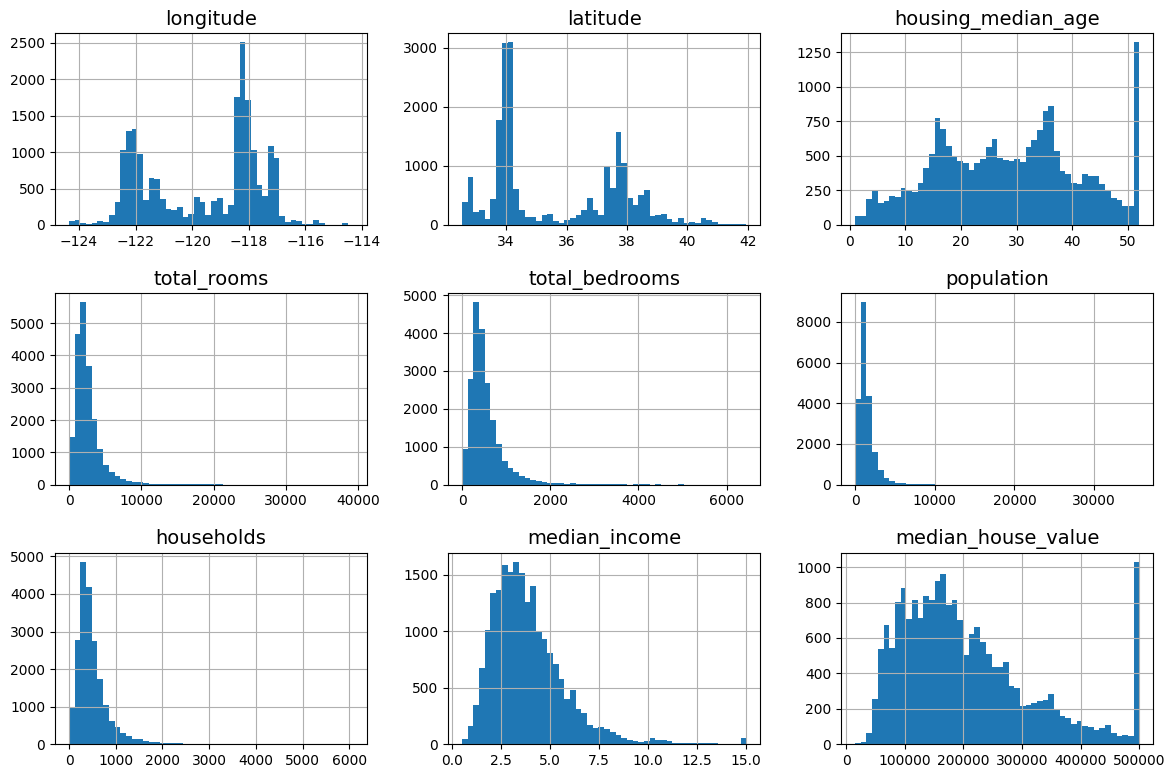

In [8]:
housing.hist(bins=50, figsize=(12,8))
save_fig("attribute_histogram_plots")
plt.show()

#### Create a Test Set

In [9]:
def shuffle_and_split_data(data, test_ratio, random_state=42):
    np.random.seed(random_state)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
print('train set:', train_set.shape, 'test set', test_set.shape)

train set: (16512, 10) test set (4128, 10)


This video provides a brief introduction to how crc32 works: https://www.youtube.com/watch?v=1NlzKh9e4Gs. 

You can also check out the Wikipedia page on crc32 at https://en.wikipedia.org/wiki/Cyclic_redundancy_check.


In [11]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, test_ratio=0.2, id_column="index")

In [13]:
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
6,6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY


In [14]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [15]:
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


In [16]:
# import train test split
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing_with_id, test_size=0.2, random_state=42)

In [17]:
test_set['total_bedrooms'].isnull().sum()

44

將`income`切分成category型。

In [18]:
housing["income_cat"] = pd.cut(housing["median_income"], 
                               bins=[0., 1.5, 3., 4.5, 6., np.inf], 
                               labels=[1, 2, 3, 4, 5])

當你畫圖時，如果使用 `hist` 函數，x 軸會是連續型的。

如果你希望 x 軸呈現為類別型資料，可以先使用 `value_counts` 函數來計算各個類別的出現次數，然後再使用 `bar` 函數繪製條形圖。

File 'housing_income_cat_hist_plot.png' already exists, use 'update=True' to overwrite


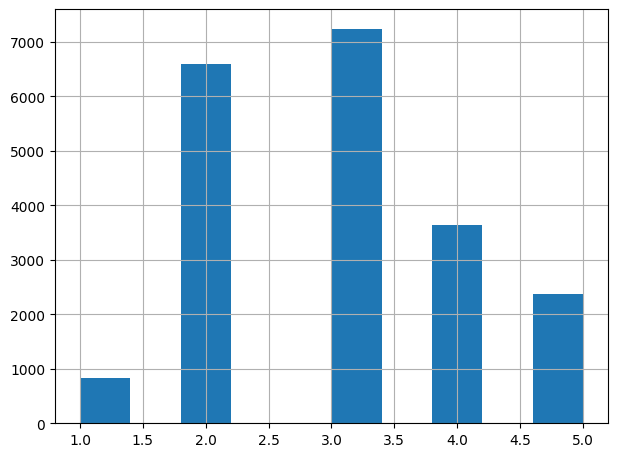

In [19]:
housing['income_cat'].hist()
save_fig("housing_income_cat_hist_plot")
plt.show()

File 'housing_income_cat_bar_plot.png' already exists, use 'update=True' to overwrite


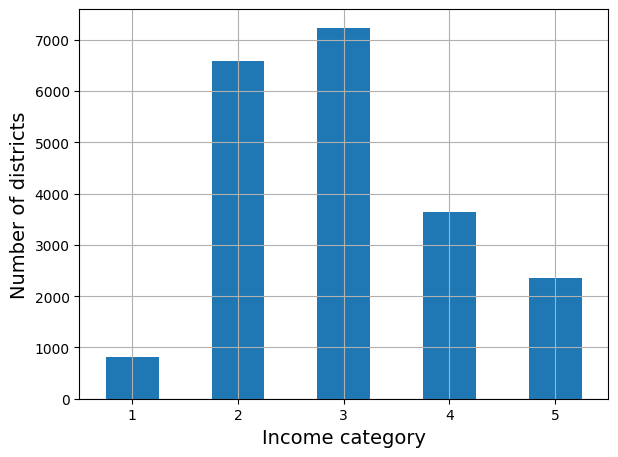

In [20]:
housing['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
save_fig("housing_income_cat_bar_plot")
plt.show()

`n_splits=1`: 分割成幾組，這裡指定為 1 組\
`test_size=0.2`: 分割出的測試集比例為 20%\
`random_state=42`: 設定隨機種子，確保每次執行時結果相同

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

`StratifiedShuffleSplit.split()` 回傳的是一個 generator，所以可以用 `for` 迴圈依序取出多組訓練集和測試集。\
當然也可以用`train_index, test_index = next(split.split(housing, housing['income_cat']))`

In [22]:
strat_splits = [] # sometimes you may construct multiple train/test sets (e.g. cross-validation)
for train_index, test_index in splitter.split(housing, housing['income_cat']):
    strat_train_set_ = housing.loc[train_index]
    strat_test_set_ = housing.loc[test_index]
    strat_splits.append([strat_train_set_, strat_test_set_])
strat_train_set, strat_test_set = strat_splits[0]

In [23]:
strat_test_set['income_cat'].value_counts(normalize=True)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: proportion, dtype: float64

In [24]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
compare_props = pd.DataFrame({
    "Overall %": housing['income_cat'].value_counts(normalize=True),
    "Stratified %": strat_test_set['income_cat'].value_counts(normalize=True),
    "Random %": test_set['income_cat'].value_counts(normalize=True),
}).sort_index()
compare_props.index.name = 'Income Category'
compare_props['Strat Error %'] = compare_props['Stratified %']/compare_props['Overall %'] - 1
compare_props['Random Error %'] = compare_props['Random %']/compare_props['Overall %'] - 1
(compare_props*100).round(2)

,Overall %,Stratified %,Random %,Strat Error %,Random Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


使用 `set_` 的目的是區別變數名稱與 set 這個 Python 內建函數。此外，在 for 迴圈中我們只是需要暫時用到 `strat_train_set` 和 `strat_test_set` 這兩個變數，因此使用底線後綴表示這些變數是暫時的，不需要保存到後面的操作中。

In [25]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

### Explore and Visualize the Data to Gain Insights
#### Visualizing Geographical Data

`pd.DataFrame.copy()` 方法的預設行為是進行深拷貝，也就是 `deep=True`。

In [26]:
housing = strat_train_set.copy()

畫scatter plot時，如果資料點過於密集，很難看出密集程度的差別。\
因此可以使用 `alpha` 參數來調整點的透明度，使得點的差異更加明顯，這對於觀察密集程度差異較大的資料特別有幫助。

File 'bad_visualization_plot.png' already exists, use 'update=True' to overwrite


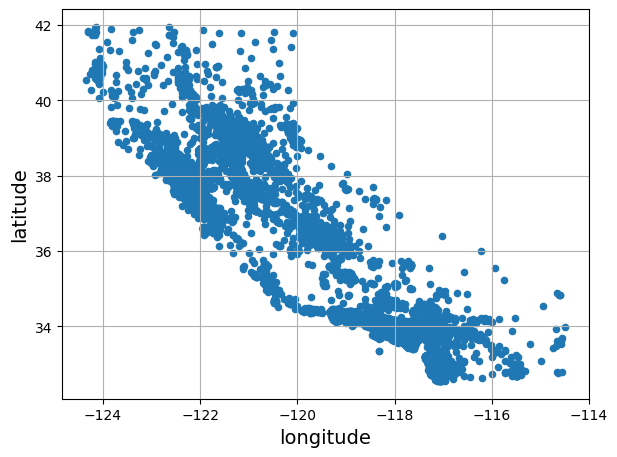

In [27]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
save_fig('bad_visualization_plot')
plt.show()

File 'better_visualization_plot.png' already exists, use 'update=True' to overwrite


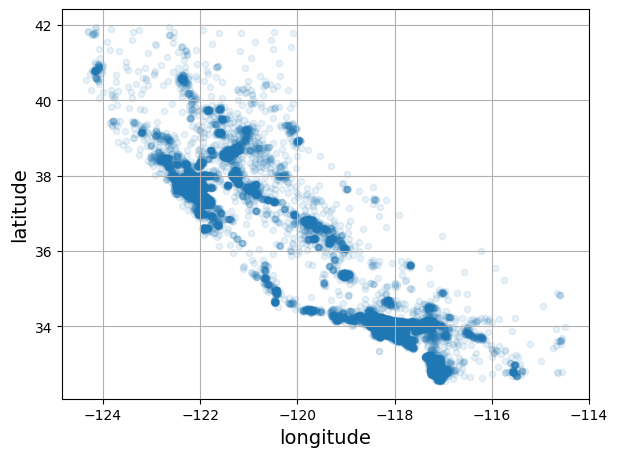

In [28]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.1)
save_fig('better_visualization_plot')
plt.show()

`s` 參數代表著每個點的半徑大小，`c` 參數代表著每個點的顏色。\
`s` 參數被設定為 `housing['population']/100`，使用每個點所代表城市的人口數來調整點的大小。\
`c` 參數被設定為 `median_house_value`，使用每個點所代表城市的房屋價格中位數來調整點的顏色。

File 'housing_price_scatterplot.png' already exists, use 'update=True' to overwrite


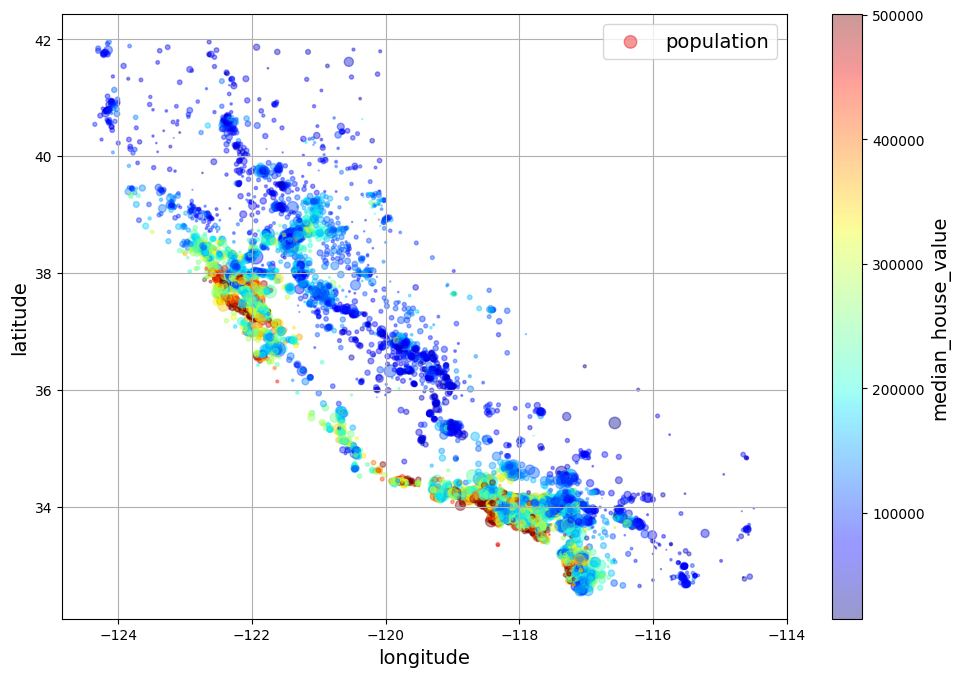

In [29]:
housing.plot(kind='scatter', x='longitude', y='latitude', s=housing['population']/100, 
             alpha = 0.4, c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True,
             legend=True, grid=True, label='population', figsize=(10,7))
save_fig('housing_price_scatterplot')
plt.show()

`imshow()`函數可以將圖像以圖像的方式顯示在軸上

File 'california_housing_prices_plot.png' already exists, use 'update=True' to overwrite


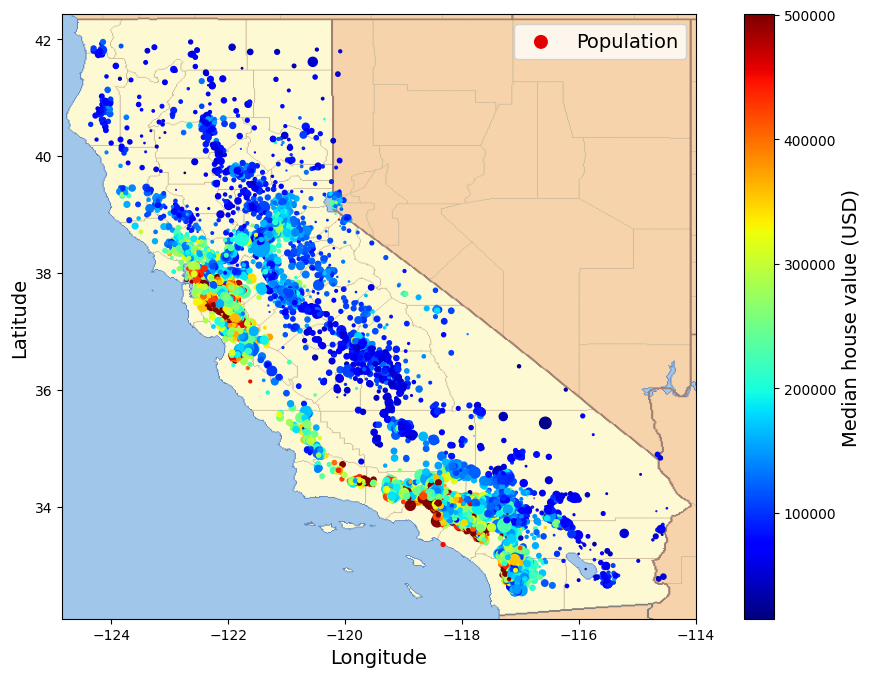

In [30]:
import matplotlib.pyplot as plt
filename = 'california.png'
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = Path(homl3_root, "images/end_to_end_project/", filename)
    print('Downloading', filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (USD)"})

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude",
                     s=housing_renamed['Population'] / 100, label="Population",
                     c="Median house value (USD)", cmap="jet", colorbar=True,
                     legend=True, figsize=(10,7))

california_img = plt.imread(IMAGES_PATH / filename)
plt.imshow(california_img, extent=[*plt.gca().get_xlim(), *plt.gca().get_ylim()])
save_fig('california_housing_prices_plot')
plt.show()

#### Look for Correlations

在 pandas 2.0.0 版本中，`numeric_only` 的默認值從 `True` 更改為 `False` 。如果希望只包括浮點數、整數或布林值，可以在使用 `corr()` 時指定 `numeric_only=True` 。

In [31]:
corr_matrix = housing.corr(numeric_only=True)

In [32]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

File 'scatter_matrix_plot.png' already exists, use 'update=True' to overwrite


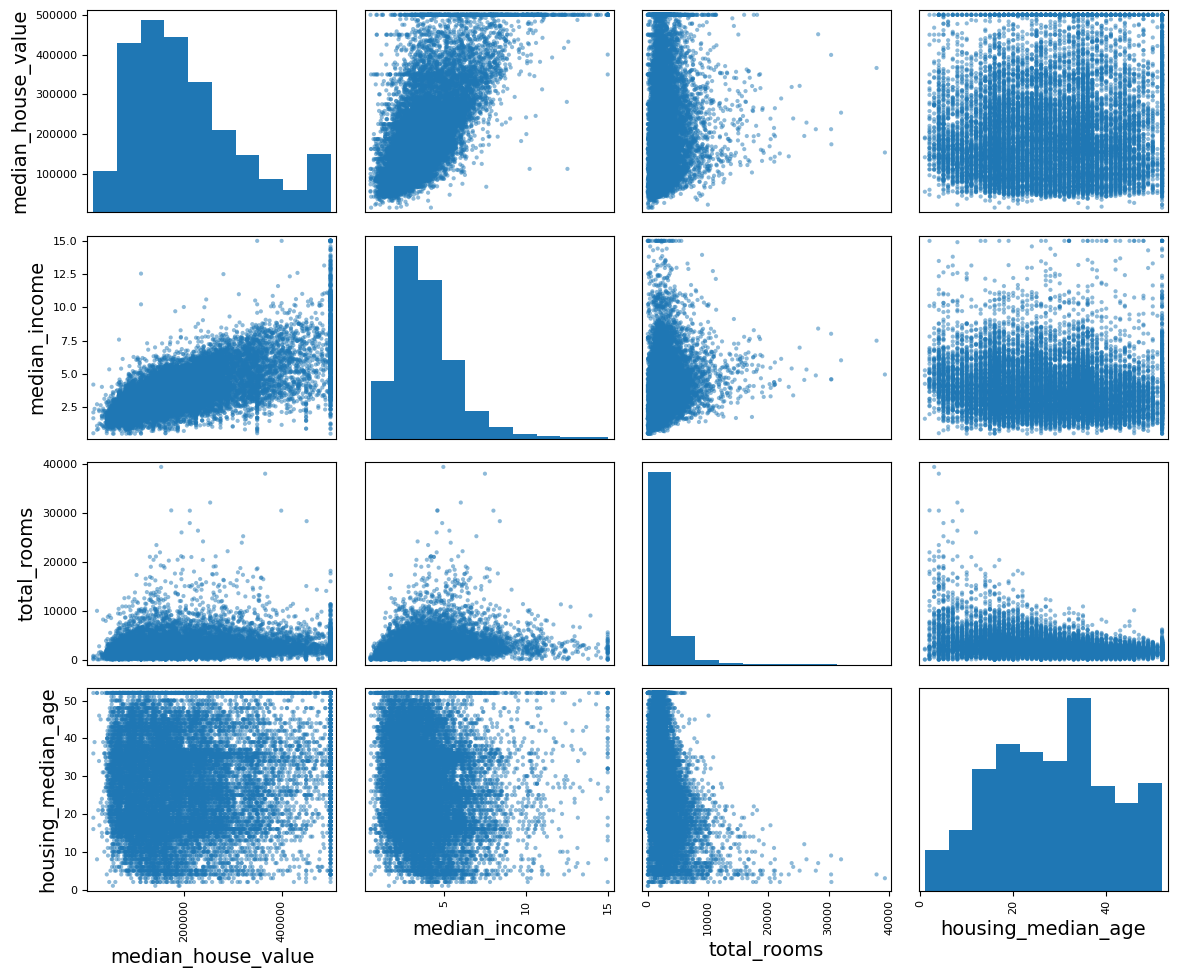

In [33]:
from pandas.plotting import scatter_matrix
attributes = attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,10))
save_fig('scatter_matrix_plot')
plt.show()

我們發現有強相關性，另外`median_house_value`在500000被截斷。

File 'income_vs_house_value_scatterplot.png' already exists, use 'update=True' to overwrite


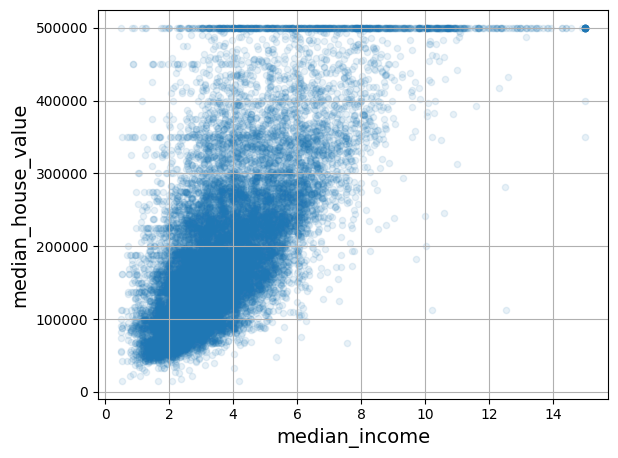

In [34]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, grid=True)
save_fig('income_vs_house_value_scatterplot')
plt.show()

#### Experiment with Attribute Combinations

In [35]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [36]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.688380
rooms_per_household    0.143663
total_rooms            0.137455
housing_median_age     0.102175
households             0.071426
total_bedrooms         0.054635
population            -0.020153
people_per_house      -0.038224
longitude             -0.050859
latitude              -0.139584
bedrooms_ratio        -0.256397
Name: median_house_value, dtype: float64

### Prepare the Data for Machine Learning Algorithms

`pd.drop()` 本身就具有複製的效果了，所以不會影響到原本的 `strat_train_set`。但 `strat_train_set['median_house_value']`就需要用 `copy()`。

In [37]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

#### Clean the Data

+ 刪除 "ocean_proximity" 欄位中含有缺失值的資料列
    ```python
    housing.dropna(subset=["total_bedrooms"], inplace=True)
    ```
+ 刪除名為 "ocean_proximity" 的欄位，若欄位含有缺失值也會被刪除
    ```python
    housing.dropna('total_bedrooms', axis=1)
    ```
+ 將 "total_bedrooms" 欄位中的缺失值以該欄位的中位數進行填補
    ```python
    housing['total_bedrooms'].fillna(housing['total_bedrooms'].median(), inplace=True)
    ```

In [38]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx,:].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [39]:
# option 1 
housing_option1 = housing.copy()
housing_option1.dropna(subset=["total_bedrooms"], inplace=True)
housing_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [40]:
# option 2
housing_option2 = housing.copy()
housing_option2.drop('total_bedrooms', axis=1, inplace=True)
housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


In [41]:
# option 3
housing_option3 = housing.copy()
median = housing_option3['total_bedrooms'].median()
housing_option3['total_bedrooms'].fillna(median, inplace=True)
housing_option3.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


`strategy` in `SimpleImputer`
+ `mean`
+ `median`
+ `most_frequent`
+ `constant`

In [42]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

In [43]:
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [44]:
# 各個變數的median
print('imputer result', imputer.statistics_, sep=':\n')
print('pandas result', housing_num.median(axis=0).values, sep=':\n')

imputer result:
[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]
pandas result:
[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]


`imputer.feature_names_in_`可以看有哪些變數被放進去這個inputer中。

In [45]:
import pandas as pd
X = imputer.transform(housing_num)
print(f"Imputer features: {imputer.feature_names_in_}")
print(f"Imputer strategy: {imputer.strategy}")

Imputer features: ['longitude' 'latitude' 'housing_median_age' 'total_rooms'
 'total_bedrooms' 'population' 'households' 'median_income']
Imputer strategy: median


In [46]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


清除outlier

In [47]:
from sklearn.ensemble import IsolationForest
isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

In [48]:
# housing = housing.iloc[outlier_pred == 1]
# housing_labels = housing_labels.iloc[outlier_pred == 1]

In [55]:
housing_cat = housing.select_dtypes(include=['object'])
housing_cat.head()

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN


In [56]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

當初被分類的categories都被保留在encoder裡面(sklearn裡的API幾乎都有這樣的特性)

In [57]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [66]:
onehot_encoder = OneHotEncoder()
housing_cat_onehot = onehot_encoder.fit_transform(housing_cat)

你會發現 `housing_cat_onehot` 只會告訴你是稀疏矩陣，因為本來裡面就很多0，這樣可以節省記憶體空間，並且可以像一般的2D array一樣使用。

In [67]:
housing_cat_onehot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

如果真的想要把他轉回2D array的話，可以用toarray，或是一開始就用關鍵字`sparse=False`
```python
OneHotEncoder(sparse=False)
```

In [68]:
housing_cat_onehot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

在encoder中有當初encode變數的相關資訊，如果之後要轉成pandas dataframe的話可以使用，

In [61]:
onehot_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [62]:
onehot_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [63]:
onehot_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [69]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [71]:
onehot_encoder.transform(df_test).toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [72]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [76]:
onehot_encoder.handle_unknown = "ignore"
onehot_encoder.transform(df_test_unknown).toarray()

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [78]:
df_output = pd.DataFrame(onehot_encoder.transform(df_test_unknown).toarray(),
                         columns=onehot_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


#### Feature Scaling and Transformation

In [80]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

當處理非常態分佈的特徵時，可以使用以下方法進行轉換：

+ 右偏的正數特徵，可以使用平方根或介於0和1之間的幂次方來替換特徵值，以使分佈縮小並接近對稱。
+ 如果右偏得非常嚴重，例如指數分佈，可以使用`log`轉換來調整。
+ 將特徵進行分桶處理，將分佈切割成大致相等大小的桶（bucket），並將特徵值替換為所屬桶的index，以獲得均勻分布的特徵。
+ 多峰分布的特徵
    - 可以考慮將特徵進行分桶，並將桶的索引視為類別值，而不是數值，以幫助模型學習不同範圍的規則。
    - 添加相似度相關的特徵。可以使用基於距離的核函數（如高斯核函數）計算特徵與固定點之間的相似度。

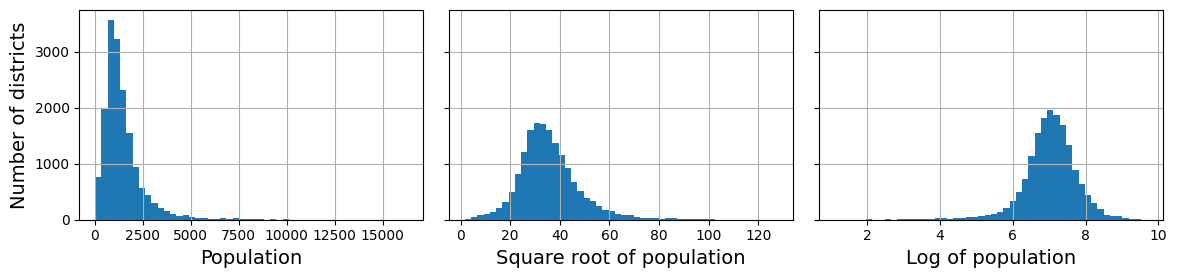

In [88]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.sqrt).hist(ax=axs[1], bins=50)
housing["population"].apply(np.log).hist(ax=axs[2], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Square root of population")
axs[2].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()

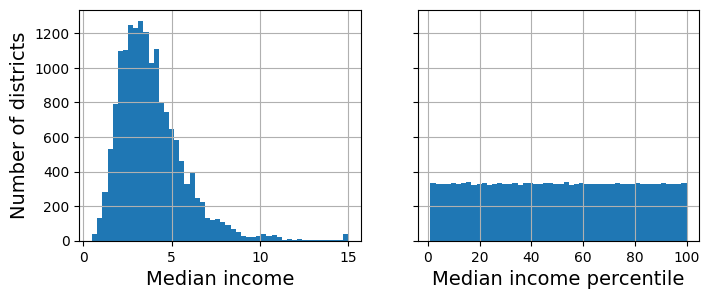

In [97]:
percentiles = np.percentile(housing["median_income"],range(1, 100)).tolist()
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["median_income"].hist(ax=axs[0], bins=50)
flattened_median_income.hist(ax=axs[1], bins=50)
# save_fig("long_tail_plot")
axs[0].set_xlabel("Median income")
axs[1].set_xlabel("Median income percentile")
axs[0].set_ylabel("Number of districts")
plt.show()

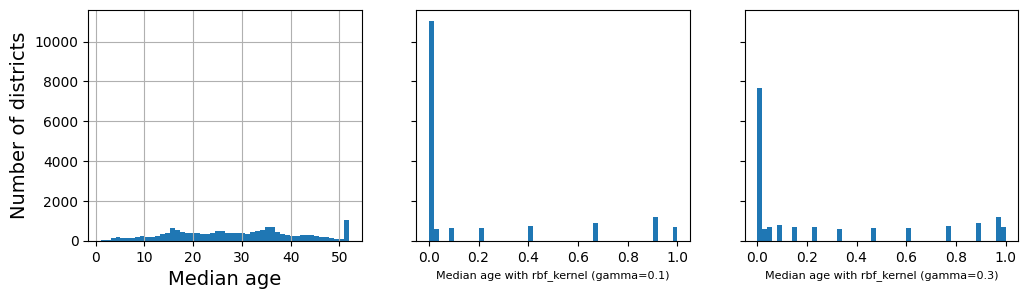

In [111]:
from sklearn.metrics.pairwise import rbf_kernel
gamma1 = 0.1
gamma2 = 0.03
rbf1_median_age = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=gamma1)
rbf2_median_age = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=gamma2)

fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
housing["housing_median_age"].hist(ax=axs[0], bins=50)
axs[1].hist(rbf1_median_age, bins=50)
axs[2].hist(rbf2_median_age, bins=50)
axs[0].set_xlabel("Median age")
axs[1].set_xlabel("Median age with rbf_kernel (gamma=0.1)", size=8)
axs[2].set_xlabel("Median age with rbf_kernel (gamma=0.3)", size=8)
axs[0].set_ylabel("Number of districts")
plt.show()

有時候我們需要對**目標變量進行轉換**，這時可以使用轉換器（transformer）中的 `inverse_transform` 方法將其**轉換回原始的目標變量**。

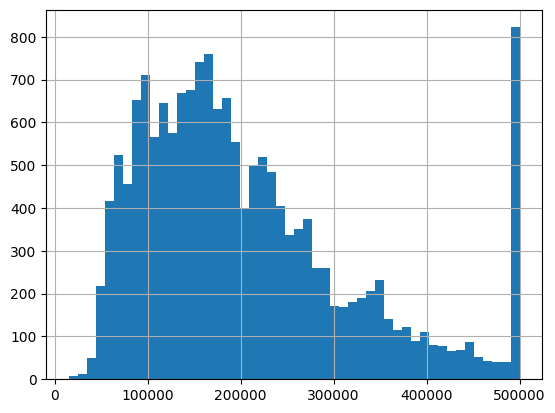

In [115]:
housing_labels.hist(bins=50)
plt.show()

In [156]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

linearmodel = LinearRegression()
linearmodel.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predictions = linearmodel.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [157]:
predictions.shape

(5, 1)

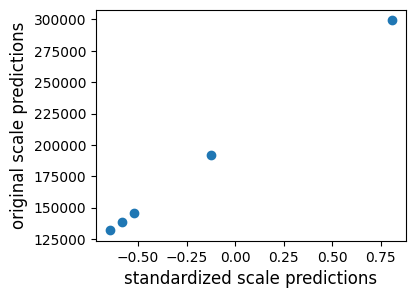

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax.scatter(scaled_predictions, predictions)
ax.set_xlabel('standardized scale predictions', size=12)
ax.set_ylabel('original scale predictions', size=12)
plt.show()

In [148]:
from sklearn.compose import TransformedTargetRegressor

tr_linearmodel = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
tr_linearmodel.fit(housing[["median_income"]], housing_labels)
predictions = tr_linearmodel.predict(some_new_data)
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

In [149]:
predictions.shape

(5,)

從 `LinearRegression().predict` 和 `TransformedTargetRegressor().predict` 獲得的predictions之間的形狀差異是由於在每種情況下處理目標變量的方式。

+ 在 `LinearRegression` 的情況下，`scaled_labels` 已經使用 `StandardScaler` 進行了轉換，從而產生形狀為 (5, 1) 的二維數組。 **當你對 `LinearRegression` 調用預測時，它會返回具有相同形狀的預測**。
+ `TransformedTargetRegressor` 使用 `StandardScaler` 在內部處理目標變量的轉換。 但是，它將目標變量以其`housing_labels` 存儲以供將來使用，例如逆變換或評估。 **當你在 TransformedTargetRegressor 調用預測時，它會以原始形式返回預測**，也就是一個形狀為 (5,) 的一維數組。

結論而言，兩種方法都會回傳跟原始數組一樣形狀的結果，但`StandardScaler`會從 (5,) 的一維數組產生形狀為 (5, 1)的二維數組。

#### Custom Transformers

我們也可以選擇客製化自己的transformer，`Sklearn`裡面有一些基礎架構可以套用，像是`BaseEstimator`, `TransformerMixin`
+ `BaseEstimator`
    + get_params(deep=True)
    + set_params(**params)
+ `TransformerMixin`
    + fit_transform(X, y=None, **fit_params)
    + set_output(*, transform=None)
    
舉例來說，如果套用了`TransformerMixin`，它的`fit_transform`會自己去抓你的transformer的`fit`跟`transform`，因為Python是用<span style="color:indianred">**鴨子型別 (duck typing)**</span>。

Duck typing是一種動態語言中的設計理念，其中**物件的有效性不是由其類型（type）本身決定**的，而是**由其方法和屬性（attributes）是否存在決定**的。這意味著當一個物件被傳遞給一個方法時，**方法將檢查物件是否有所需的方法和屬性，而不是檢查物件的類型**。這種方法使得代碼更加靈活，因為它可以處理不同的物件，只要它們具有所需的方法和屬性即可。通常，Duck typing是動態語言如Python的特點，而靜態語言如Java通常不使用這種技術。

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin
idx = housing.columns.get_indexer(['total_rooms', 'total_bedrooms', 'population', 'households'])
rooms_idx, bedrooms_idx, population_idx, households_idx = idx

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_idx] / X[:, households_idx]
        population_per_household = X[:, population_idx] / X[:, households_idx]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_idx] / X[:, rooms_idx]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.fit(housing.values)

## Feature Scaling
通常會有 <span style = "color: Indianred"> min-max scaling (normalization) </span>  或是 <span style="color:Indianred"> standardization </span>。

In [54]:
np.random.seed(42)
test_X = np.random.rand(15).reshape(3, 5)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
standardscaler = StandardScaler()
minmaxscaler = MinMaxScaler()

standardscaler.fit(test_X)
print("standardscaler", standardscaler.transform(test_X), sep=':\n')

minmaxscaler.fit(test_X)
print("minmaxscaler", minmaxscaler.transform(test_X), sep=':\n')

standardscaler:
[[ 1.30865495  0.68442432 -1.37230404  0.70037308 -0.75722475]
 [-0.19003589 -1.41397357  0.98210169  0.71381918  1.41300012]
 [-1.11861906  0.72954925  0.39020235 -1.41419226 -0.65577537]]
minmaxscaler:
[[1.         0.97894824 0.         0.99368138 0.        ]
 [0.38256215 0.         1.         1.         1.        ]
 [0.         1.         0.74859926 0.         0.04674602]]


轉換Pipeline有對應的API，可以將整個的Transform Flow存下來。

In [55]:
from sklearn.pipeline import Pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attributes_adder', CombinedAttributesAdder()),
    ('standardscaler', StandardScaler())
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

可以用`named_steps`找到全部的步驟，也可以存取步驟的statistic。

In [56]:
num_pipeline.named_steps

{'imputer': SimpleImputer(strategy='median'),
 'attributes_adder': CombinedAttributesAdder(),
 'standardscaler': StandardScaler()}

In [57]:
num_pipeline.named_steps.imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

有另外一種方式可以不用命名transformer，一樣在`sklearn.pipeline`裡的`make_pipeline`

In [58]:
from sklearn.pipeline import make_pipeline
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), CombinedAttributesAdder(), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

In [59]:
num_pipeline.fit(housing_num)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('combinedattributesadder', CombinedAttributesAdder()),
                ('standardscaler', StandardScaler())])

一樣可以用`named_steps`找到全部的步驟，也可以存取步驟的statistic，差別只在不用取名字，還有pipeline的方式。

In [60]:
num_pipeline.named_steps

{'simpleimputer': SimpleImputer(strategy='median'),
 'combinedattributesadder': CombinedAttributesAdder(),
 'standardscaler': StandardScaler()}

In [61]:
num_pipeline.named_steps.simpleimputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [62]:
onehotencoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

不同的columns可能會需要不同的pipeline，以下API，可以有效地解決這個問題。\
`sklearn.compose`: Composite Estimators: Meta-estimators for building composite models with transformers

In [63]:
from sklearn.compose import ColumnTransformer
numeric_features = list(housing_num)
categorical_features = list(housing_cat) # in fact, 'ocean_proximity' is the only categorical features

In [64]:
processing = ColumnTransformer([
    ('num', num_pipeline, numeric_features),
    ('cat', cat_pipeline, categorical_features)
])

housing_prepared = processing.fit_transform(housing)

但自己抓feature要走哪一條pipeline實在太辛苦了，所以Sklearn裡面也有自己抓columns的API。\
同時，如果你懶得幫`ColumnTransformer`每個transformer取名字的話，你也可以用`make_column_transformer`來做剛剛`ColumnTransformer`在做的事情，就像剛剛`make_pipeline`可以取代`Pipeline`一樣。

In [66]:
from sklearn.compose import make_column_selector, make_column_transformer
processing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)
housing_prepared = processing.fit_transform(housing)